In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import qutip as qt

In [2]:
dpath = "data\\pns-data-1024\\"

In [3]:
def power_to_kappa(power, kappa=0.1):
    power2 = np.array(power)
    power2 -= 40.0 # attenuation
    power2 = np.sqrt(10**((power2)/10)*0.001*50) # power to RMS voltage
    power2 *= 2*np.sqrt(2) # RMS to p2p voltage
    power2 *= (84.34 + 73.44) # polariton rabi rates in MHz
    power2 /= kappa
    return power2

# Load Raw Spectrum Data

In [34]:
idxs_lowP = np.concatenate([range(4,14), range(51,62)])

In [35]:
df = pd.read_csv(dpath + f'Q{4}-pns-power-{idxs_lowP[0]}.csv')

freqs = np.unique(df['frequency'])
buspows = np.unique(df['buspower'])
phase = np.array(df['phase']).reshape([len(buspows), len(freqs)])
phase = phase.transpose() - np.mean(phase[-50:, :], axis=1)
phase = np.unwrap(phase)
phase = scipy.signal.savgol_filter(phase, 11, 3, axis=0)

# Load sim

In [4]:
dpath_sim = "data\\simulation\\"

In [5]:
df_yeswit = pd.read_csv(dpath_sim + 'N1-g2-733-35p5-yeswit.csv')

In [6]:
amps_sim_yeswit = np.unique(np.array(df_yeswit['amp']))
deltas_sim_yeswit = np.unique(np.array(df_yeswit['detune']))
g2s_sim_yeswit = np.array(df_yeswit['g2']).reshape([len(deltas_sim_yeswit), len(amps_sim_yeswit)])

In [8]:
df_nowit = pd.read_csv(dpath_sim + 'N1-g2-733-35p5-nowit.csv')

In [9]:
amps_sim_nowit = np.unique(np.array(df_nowit['amp']))
deltas_sim_nowit = np.unique(np.array(df_nowit['detune']))
g2s_sim_nowit = np.array(df_nowit['g2']).reshape([len(deltas_sim_nowit), len(amps_sim_nowit)])

# Load Experimental g2

In [11]:
df = pd.read_csv('fit-results\\g2-N1-exp.csv')
detune_N1 = np.unique(np.array(df['detuning']))
amp_N1 = np.unique(np.array(df['power']))
g2_N1_arr = np.array(df['g2']).reshape([len(detune_N1), len(amp_N1)])

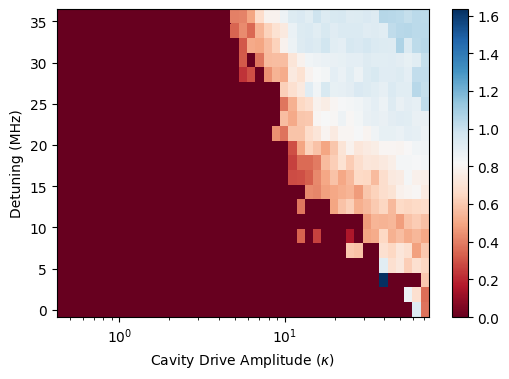

In [12]:
plt.figure(figsize=(6,4))
g2_N1_arr[np.isnan(g2_N1_arr)] = 0
plt.pcolor(power_to_kappa(amp_N1), np.flip(detune_N1)/1e6, g2_N1_arr, cmap='RdBu')
plt.xscale('log')
plt.xlabel('Cavity Drive Amplitude ($\kappa$)')
plt.ylabel('Detuning (MHz)')
plt.colorbar()
plt.show()

In [38]:
g2_trace = g2_N1_arr[0,:]

# Load Experimental Peak Weights and Positions

In [41]:
df = pd.read_csv("fit-results\\N1-photon-pops.csv")

In [42]:
detuning_exp = np.unique(np.array(df['detuning']))
power_exp = np.unique(np.array(df['power']))
ns_exp = np.unique(np.array(df['n']))
pops_exp = np.array(df['pop']).reshape([len(power_exp), len(detuning_exp), len(ns_exp)])
freqs_exp = np.array(df['freq']).reshape([len(power_exp), len(detuning_exp), len(ns_exp)])

# Compile Figure

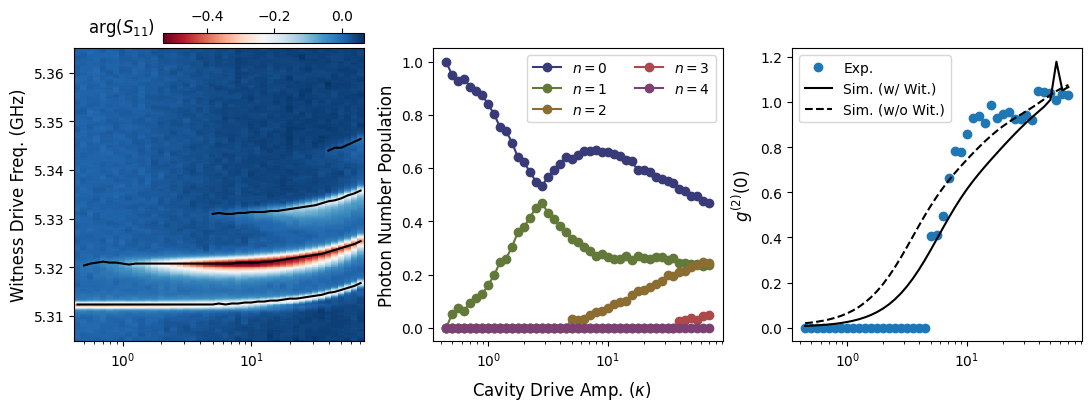

In [45]:
# colors = plt.cm.plasma(np.linspace(0, 1, 5))
# colors = plt.cm.tab20b([1, 5, 9, 13, 17])
colors = plt.cm.tab20b([0, 4, 8, 13, 16])
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
fig.subplots_adjust(wspace=0.24)
im = axs[0].pcolor(power_to_kappa(buspows), freqs/1e9, phase, cmap='RdBu', rasterized='auto')
axs[0].set_ylim(None, 5.365)
axs[0].set_ylabel('Witness Drive Freq. (GHz)', fontsize=12)
axs[0].set_xscale('log')
fig.supxlabel('Cavity Drive Amp. ($\kappa$)', fontsize=12, y=-0.04)
for i in range(5):
    if i < 4:
        axs[1].plot(power_to_kappa(buspows), pops_exp[:,0,i], 'o-', label=f'$n={i}$', color=colors[i])
        ftemp = []
        ptemp = []
        for j in range(len(buspows)):
            if freqs_exp[j,0,i] > 0.1:
                ftemp.append(freqs_exp[j,0,i])
                ptemp.append(buspows[j])
        axs[0].plot(power_to_kappa(np.array(ptemp)), np.array(ftemp)/1e9, color='k')
    else:
        axs[1].plot(power_to_kappa(buspows), np.zeros(len(buspows)), 'o-', label=f'$n={i}$', color=colors[i])
axs[1].legend(ncols=2)
axs[1].set_ylabel('Photon Number Population', fontsize=12)
axs[1].set_xscale('log')
axs[2].plot(power_to_kappa(buspows), g2_trace, 'o', label='Exp.')
axs[2].set_xscale('log')
axs[2].set_ylabel('$g^{(2)}(0)$', fontsize=12)
axs[2].plot(amps_sim_yeswit/0.1, g2s_sim_yeswit[0,:], color='k', label='Sim. (w/ Wit.)')
axs[2].plot(amps_sim_nowit/0.1, g2s_sim_nowit[0,:], '--', color='k', label='Sim. (w/o Wit.)')
axs[2].legend()
cb = fig.colorbar(im, ax=axs.ravel().tolist(), location='top', anchor=(0.11,1.0), shrink=0.2, pad=-0.10)
cb.ax.set_ylabel('$\mathrm{arg}(S_{11})$', rotation=0, labelpad=30, fontsize=12)
# fig.tight_layout()
fig.savefig('figures\\fig-extract-g2.pdf', bbox_inches='tight')

In [88]:
power_to_kappa(buspows)[0], power_to_kappa(buspows)[-1]

(np.float64(0.44574034758115627), np.float64(70.64508424866254))